In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [3]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTEENN
import optuna as op

In [4]:
df = pd.read_csv("bank-full.csv", sep=";")

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.shape

(45211, 17)

In [7]:
df["y"].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [8]:
df["month"].unique().shape

(12,)

In [9]:
cate = {
    "education": {"unknown":0, "primary":1, "secondary":2, "tertiary":3},
    "month": {"mar": "Spring", "apr": "Spring", "may": "Spring", 
              "jun": "Summer", "jul": "Summer", "aug": "Summer",
              "sep": "Autumn", "oct": "Autumn", "nov": "Autumn",
              "dec": "Winter", "jan": "Winter", "feb": "Winter"},
    "y": {"yes":1, "no":0}
}


In [10]:
df = df.replace(cate)
df = df.replace({"unknown": "AA"})#for drop first

In [11]:
 df.describe()

,age,education,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,2.060516,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,0.778704,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,0.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,2.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,2.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,3.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,3.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [12]:
df['balance_outliers'] = df['balance']
df['balance_outliers']= zscore(df['balance_outliers'])

condition1 = (df['balance_outliers']>3) | (df['balance_outliers']<-3 )
df2 = df.drop(df[condition1].index, axis = 0, inplace = False)
df2 = df2.drop('balance_outliers', axis=1)

In [13]:
df2.shape, df.shape

((44466, 17), (45211, 18))

In [14]:
45211 - 44466

745

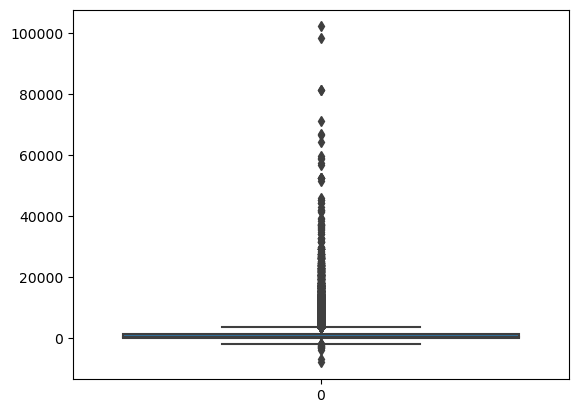

In [15]:
sns.boxplot(df['balance'])
plt.show()

<AxesSubplot: >

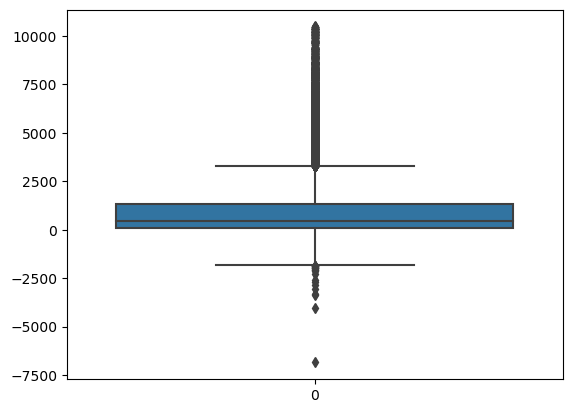

In [16]:
sns.boxplot(df2['balance'])

In [17]:
df2.describe()

,age,education,balance,day,duration,campaign,pdays,previous,y
count,44466.000000,44466.000000,44466.000000,44466.000000,44466.000000,44466.000000,44466.000000,44466.000000,44466.000000
mean,40.882382,2.056403,1084.544483,15.803558,258.057662,2.765506,40.244614,0.579544,0.116224
std,10.596139,0.777141,1721.069271,8.328517,257.439656,3.100462,100.268044,2.310143,0.320497
min,18.000000,0.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,2.000000,68.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,2.000000,431.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,3.000000,1347.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,3.000000,10483.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [18]:
df = pd.get_dummies(df2,drop_first=True)
print(df.shape)
df.head()

(44466, 33)


,age,education,balance,day,duration,campaign,pdays,previous,y,job_admin.,...,housing_yes,loan_yes,contact_cellular,contact_telephone,month_Spring,month_Summer,month_Winter,poutcome_failure,poutcome_other,poutcome_success
0,58,3,2143,5,261,1,-1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,44,2,29,5,151,1,-1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,33,2,2,5,76,1,-1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
3,47,0,1506,5,92,1,-1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,33,0,1,5,198,1,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [19]:
df2.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [20]:
df2['y'].value_counts()

0    39298
1     5168
Name: y, dtype: int64

In [21]:
5168/39298

0.13150796478192275

Text(0.5, 0, "['No', 'Yes']")

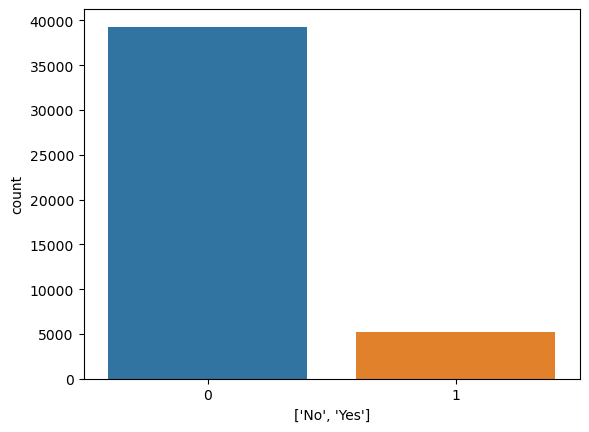

In [22]:
sns.countplot(x='y', data=df2)
plt.xlabel(['No', 'Yes'])

In [23]:
df2.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [24]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df2.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Unknown Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df2)

No NAs found


In [25]:
# df.to_csv("bank.csv", index=False)

In [26]:
y = df["y"]
X = df.drop("y", axis=1)
X.head()

,age,education,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,...,housing_yes,loan_yes,contact_cellular,contact_telephone,month_Spring,month_Summer,month_Winter,poutcome_failure,poutcome_other,poutcome_success
0,58,3,2143,5,261,1,-1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,44,2,29,5,151,1,-1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,33,2,2,5,76,1,-1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
3,47,0,1506,5,92,1,-1,0,0,1,...,1,0,0,0,1,0,0,0,0,0
4,33,0,1,5,198,1,-1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
N_FOLD = 10
STD = True
N_TRIALS = 20
SEED = 2

SOLVER ='liblinear'
if STD:
    SOLVER = 'saga'

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

X_train.shape, X_test.shape

((31126, 32), (13340, 32))

In [29]:
SAMPLING = "SMOTE"
smote = SMOTE()
X_train_hat, y_train_hat = smote.fit_resample(X_train, y_train)
y_train_hat.value_counts()

0    27539
1    27539
Name: y, dtype: int64

In [30]:
if STD:
        scaler = StandardScaler()
        scaler.fit(X_train_hat)
        X_train_hat = scaler.transform(X_train_hat)
        X_train_hat = pd.DataFrame(X_train_hat, columns=X.columns)
        
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=X.columns)
        
X_train_hat.shape, X_test.shape

((55078, 32), (13340, 32))

In [31]:
def kf_confusion_matrix(model, X, y, fold, std=False, remove=None):
    k_fold = KFold(fold, shuffle=True, random_state=SEED)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(X):
        train_x, train_y= X.iloc[train_ix], y.iloc[train_ix]
        test_x, test_y= X.iloc[test_ix], y.iloc[test_ix]
        
        smote = SMOTE()
        train_x, train_y = smote.fit_resample(train_x, train_y)
        
        if std:
            s = StandardScaler()
            s.fit(train_x)
            train_x = s.transform(train_x)
            test_x = scaler.transform(test_x)
            
        # Fit the classifier
        m = model.fit(train_x, train_y)

        # Predict the labels of the test set samples
        if remove:
            predicted_labels = m.predict(train_x[remove])
        else:    
            predicted_labels = m.predict(test_x)


        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [32]:
logr = LogisticRegression(penalty='none', n_jobs=-1, max_iter=1000)
logr.fit(X_train_hat, y_train_hat)

print('Test')
y_pred = logr.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))
report = classification_report(y_test, y_pred, digits=8, output_dict=True)

print("-"*60)
print("Train")
y_pred = logr.predict(X_train_hat)
print(classification_report(y_train_hat, y_pred, digits=5))
report = classification_report(y_train_hat, y_pred, digits=8, output_dict=True)



Test
              precision    recall  f1-score   support

           0    0.92473   0.94864   0.93653     11759
           1    0.52702   0.42568   0.47096      1581

    accuracy                        0.88666     13340
   macro avg    0.72587   0.68716   0.70374     13340
weighted avg    0.87759   0.88666   0.88135     13340

------------------------------------------------------------
Train
              precision    recall  f1-score   support

           0    0.90228   0.94855   0.92484     27539
           1    0.94576   0.89727   0.92088     27539

    accuracy                        0.92291     55078
   macro avg    0.92402   0.92291   0.92286     55078
weighted avg    0.92402   0.92291   0.92286     55078



In [34]:
c = np.arange(0.01, 0.3, 0.01)
scores_train = []
scores_test = []
f1_train = []
f1_test = []
n = 0
for a in c:
    ridge = LogisticRegression(penalty='l2',C=a, solver=SOLVER, random_state=SEED, n_jobs=-1)
    ridge.fit(X_train_hat, y_train_hat)
    
    y_pred = ridge.predict(X_test)
    report = classification_report(y_test, y_pred, digits=8, output_dict=True)
    s_test = report["accuracy"]
    f_test = report["1"]["f1-score"]
    
    y_pred = ridge.predict(X_train_hat)
    report = classification_report(y_train_hat, y_pred, digits=8, output_dict=True)
    s_train = report["accuracy"]
    f_train = report["1"]["f1-score"]

    scores_test.append(s_test)
    f1_test.append(f_test)
    
    scores_train.append(s_train)
    f1_train.append(f_train)
    n+=1

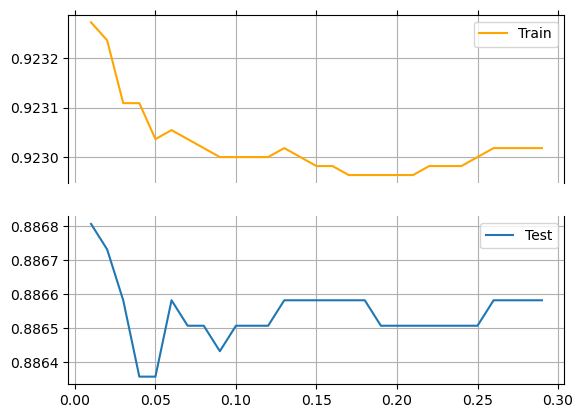

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(c, scores_train, label="Train", color='orange')
ax2.plot(c, scores_test, label="Test")

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

ax1.grid(True)
ax2.grid(True)

ax1.legend()
ax2.legend()
plt.show()

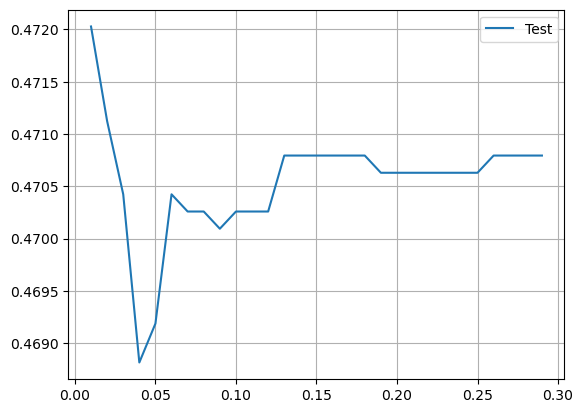

In [36]:
# sns.lineplot(x=c, y=f1_train, label="Cross_val", color="red")
sns.lineplot(x=c, y=f1_test, label="Test")
plt.grid(True)
plt.show()

In [37]:
def ridge_objective(trial):
    #Parameters to tune
    _alpha = trial.suggest_float("alpha",0.001, 0.3)
    
    #model
    ridge = LogisticRegression(penalty='l2', C=_alpha, max_iter=1000,solver=SOLVER, 
                               random_state=SEED, n_jobs=-1)
    y_pred, y_true = kf_confusion_matrix(ridge, X_train, y_train, N_FOLD, std=STD)
    
    #what to optimize 
    report = classification_report(y_true, y_pred, digits=8, output_dict=True)
    scores = report["1.0"]["f1-score"]
    return scores

study = op.create_study(direction="maximize")
study.optimize(ridge_objective, n_trials=N_TRIALS)
best_params = study.best_params
best_score = study.best_value

[I 2022-11-05 21:18:36,604] A new study created in memory with name: no-name-27e87846-7cce-4828-abf0-3a9360fa2331
[I 2022-11-05 21:18:48,647] Trial 0 finished with value: 0.46284043699030625 and parameters: {'alpha': 0.059614257356018496}. Best is trial 0 with value: 0.46284043699030625.
[I 2022-11-05 21:19:02,181] Trial 1 finished with value: 0.4632194521391197 and parameters: {'alpha': 0.19345581968959155}. Best is trial 1 with value: 0.4632194521391197.
[I 2022-11-05 21:19:13,887] Trial 2 finished with value: 0.46395080707148345 and parameters: {'alpha': 0.047022054252466514}. Best is trial 2 with value: 0.46395080707148345.
[I 2022-11-05 21:19:27,150] Trial 3 finished with value: 0.4634296250768285 and parameters: {'alpha': 0.157663931663215}. Best is trial 2 with value: 0.46395080707148345.
[I 2022-11-05 21:19:41,551] Trial 4 finished with value: 0.4629089233604669 and parameters: {'alpha': 0.2216123499875782}. Best is trial 2 with value: 0.46395080707148345.
[I 2022-11-05 21:19:5

In [38]:
print(best_params)
print('Test')
ridge = LogisticRegression(penalty='l2', C=best_params['alpha'],solver=SOLVER, random_state=SEED)
ridge.fit(X_train_hat, y_train_hat)
y_pred = ridge.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

print('-'*60)

print('Train')
y_pred = ridge.predict(X_train_hat)
print(classification_report(y_train_hat, y_pred, digits=5))



{'alpha': 0.16107775546838438}
Test
              precision    recall  f1-score   support

           0    0.92472   0.94855   0.93648     11759
           1    0.52660   0.42568   0.47079      1581

    accuracy                        0.88658     13340
   macro avg    0.72566   0.68711   0.70364     13340
weighted avg    0.87754   0.88658   0.88129     13340

------------------------------------------------------------
Train
              precision    recall  f1-score   support

           0    0.90238   0.94858   0.92490     27539
           1    0.94581   0.89738   0.92096     27539

    accuracy                        0.92298     55078
   macro avg    0.92409   0.92298   0.92293     55078
weighted avg    0.92409   0.92298   0.92293     55078



In [39]:
c = np.arange(0.0001, 0.03, 0.0005)
scores_train = []
scores_test = []
f1_train = []
f1_test = []
n = 0
for a in c:
    lasso = LogisticRegression(penalty='l1',C=a, solver=SOLVER, random_state=SEED, n_jobs=-1)
    lasso.fit(X_train_hat, y_train_hat)
    
    y_pred = lasso.predict(X_test)
    report = classification_report(y_test, y_pred, digits=8, output_dict=True)
    s_test = report["accuracy"]
    f_test = report["1"]["f1-score"]
    
    y_pred = lasso.predict(X_train_hat)
    report = classification_report(y_train_hat, y_pred, digits=8, output_dict=True)
    s_train = report["accuracy"]
    f_train = report["1"]["f1-score"]

    scores_test.append(s_test)
    f1_test.append(f_test)
    
    scores_train.append(s_train)
    f1_train.append(f_train)
    n+=1

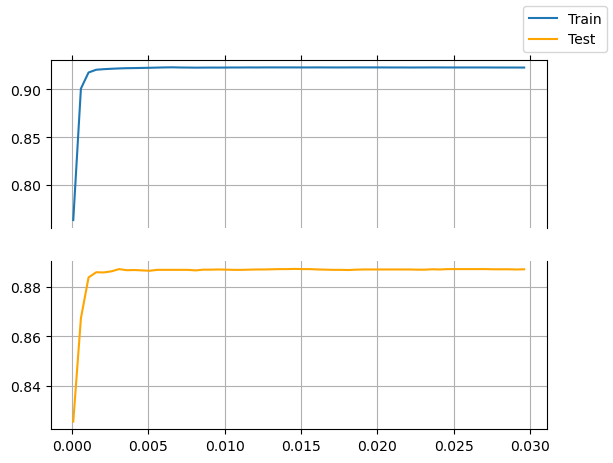

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(c, scores_train, label="Train")
ax2.plot(c, scores_test, label="Test", color="orange")

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False) 
ax2.xaxis.tick_bottom()

ax1.grid(True)
ax2.grid(True)

fig.legend()
plt.show()

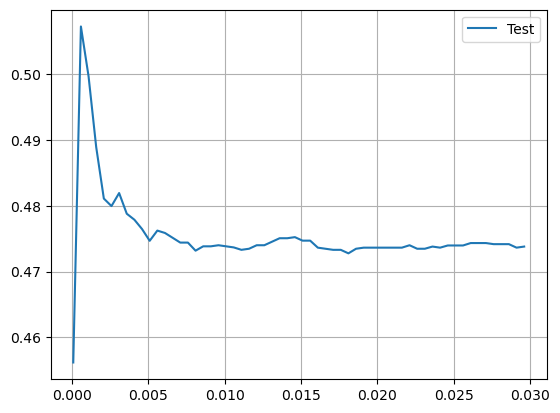

In [41]:
sns.lineplot(x=c, y=f1_test, label="Test")
plt.grid(True)
plt.show()

In [42]:
def lasso_objective(trial):
    #Parameters to tune
    _alpha = trial.suggest_float("alpha",0.0001, 0.03)
    
    #model
    lasso = LogisticRegression(penalty='l1', C=_alpha, max_iter=1000,solver=SOLVER, 
                               random_state=SEED, n_jobs=-1)
    y_pred, y_true = kf_confusion_matrix(lasso, X_train, y_train, N_FOLD, std=STD)
    
    #what to optimize 
    report = classification_report(y_true, y_pred, digits=8, output_dict=True)
    scores = report["1.0"]["f1-score"]
    return scores

study = op.create_study(direction="maximize")
study.optimize(lasso_objective, n_trials=N_TRIALS)
best_params = study.best_params
best_score = study.best_value

[I 2022-11-05 21:24:04,477] A new study created in memory with name: no-name-fe6ac21e-aee0-4e2d-9673-cb8a962244fd
[I 2022-11-05 21:24:16,756] Trial 0 finished with value: 0.46631805598277454 and parameters: {'alpha': 0.020305154785953353}. Best is trial 0 with value: 0.46631805598277454.
[I 2022-11-05 21:24:25,451] Trial 1 finished with value: 0.46974107553240385 and parameters: {'alpha': 0.006907224642895474}. Best is trial 1 with value: 0.46974107553240385.
[I 2022-11-05 21:24:37,300] Trial 2 finished with value: 0.46588813767670556 and parameters: {'alpha': 0.017765370428704866}. Best is trial 1 with value: 0.46974107553240385.
[I 2022-11-05 21:24:50,836] Trial 3 finished with value: 0.4646651270207852 and parameters: {'alpha': 0.029858372295546342}. Best is trial 1 with value: 0.46974107553240385.
[I 2022-11-05 21:24:59,095] Trial 4 finished with value: 0.47013782542113325 and parameters: {'alpha': 0.006012164474685916}. Best is trial 4 with value: 0.47013782542113325.
[I 2022-11-0

In [43]:
print(best_params)
print('Test')
ridge = LogisticRegression(penalty='l1', C=best_params['alpha'],solver=SOLVER, random_state=SEED)
ridge.fit(X_train_hat, y_train_hat)
y_pred = ridge.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

print('-'*60)
print('Train')
y_pred = ridge.predict(X_train_hat)
print(classification_report(y_train_hat, y_pred, digits=5))
report = classification_report(y_train_hat, y_pred, digits=8, output_dict=True)



{'alpha': 0.0011946537378117825}
Test
              precision    recall  f1-score   support

           0    0.93091   0.93962   0.93525     11759
           1    0.51734   0.48134   0.49869      1581

    accuracy                        0.88531     13340
   macro avg    0.72412   0.71048   0.71697     13340
weighted avg    0.88190   0.88531   0.88351     13340

------------------------------------------------------------
Train
              precision    recall  f1-score   support

           0    0.90182   0.93954   0.92029     27539
           1    0.93690   0.89771   0.91689     27539

    accuracy                        0.91862     55078
   macro avg    0.91936   0.91862   0.91859     55078
weighted avg    0.91936   0.91862   0.91859     55078



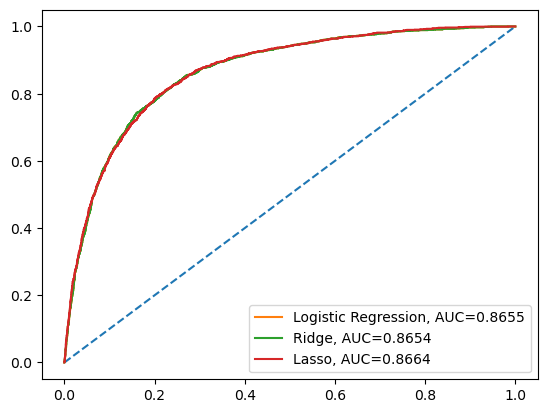

In [44]:
plt.figure(0).clf()
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--')


lr = LogisticRegression(penalty='none', random_state=SEED)
lr.fit(X_train_hat, y_train_hat)
y_pred = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

ridge = LogisticRegression(penalty='l2',C=0.24456998352859904, solver=SOLVER, random_state=SEED)
ridge.fit(X_train_hat, y_train_hat)
y_pred = ridge.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Ridge, AUC="+str(auc))

lasso = LogisticRegression(penalty='l1',C=0.001003907311714561, solver=SOLVER, random_state=SEED)
lasso.fit(X_train_hat, y_train_hat)
y_pred = lasso.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Lasso, AUC="+str(auc))

plt.legend()
plt.show()